## MSCA 34001 -  Supply Chain Social Economic Risk Estimation using News Articles 


###  Loading and pre-processing the dataset

### Import required libraries

In [1]:
# Load libraries for analysis and visualization
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
from collections import Counter

%matplotlib inline



# Machine learning libraries
import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics
import sklearn         # Collection of machine learning algorithms
import sklearn.ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix
# using Vader for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
#nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from time import strftime, localtime
from datetime import datetime

import pickle

import warnings
warnings.filterwarnings('ignore')

# Elastic Search API - Connecting and pulling data

In [2]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from time import time, sleep, strftime, localtime
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [3]:
from Utils.ESearch import *

In [4]:
#Define some helper functions here
def format_json(obj, indent=2):
    return json.dumps(obj, indent=indent)

def datetime_to_epoch(year,mon,day,h=0,m=0,s=0):
    return int(datetime(year,mon,day,h,m,s).timestamp())

def epoch_to_datetime(epoch):
    return strftime('%Y-%m-%d %H:%M:%S', localtime(epoch))

In [5]:
INDEX_NAME = "article_data"
INDEX_VENDOR = "vendor_data"

### Connect to ElasticSearch

In [6]:
### Get total number of articles that match a condition

query = None
# query = {"match":{
#                     "Title" : {
#                                 "query" : "Reserch",
#                                 "fuzziness" : 1
#                             }
#                   }
#               }

# query = {"range":{
#                     "Scrape_Date": {
#                         "gte":datetime_to_epoch(2020, 1, 24, 11, 43, 46),
#                         "lt":datetime_to_epoch(2020, 1, 25, 11, 43, 48)
#                     }
#                 }
#             }
#get_count(es, INDEX_NAME, query=query)

In [7]:
print('Reading articles from ES')
es = connect_to_es()

if (index_exists(es, INDEX_NAME)):
    data = get_data(es, INDEX_NAME, query=query)
    print('Number of articles from ES:', len(data))

if (index_exists(es, INDEX_VENDOR)):
    dataVendor = get_data(es, INDEX_VENDOR, query=query)
    print('Number of vendors from ES:', len(dataVendor))

Reading articles from ES
Number of articles from ES: 3733
Number of vendors from ES: 768


In [8]:
data = pd.read_excel("articles_to_enriched.xlsx")

In [9]:
def simply_to_date(epoch):
    return datetime.strptime(strftime('%m-%d-%Y', localtime(epoch/1000)), '%m-%d-%Y').date()

In [10]:
data['Publish_Date_Clean'] = data['Publish_Date'].map(lambda x: simply_to_date(x))

TypeError: unsupported operand type(s) for /: 'Timestamp' and 'int'

In [11]:
# dropping ALL duplicate values by URLs
df_all = data.drop_duplicates(subset ='URL', keep = False)

#Rename column names to standardized values
df_all.columns = [x.lower() for x in df_all.columns]

In [12]:
se_cols = ['id','se_abbv_close',  'se_abbv_open',
        'se_is_risk', 'se_risk_rating',
       'se_sentimentpolarity', 'se_sentimentscore', 'se_snp_close',
        'se_snp_open', 
       'se_xbi_close', 'se_xbi_open',
        'source', 'text', 'title', 'url', 
           'se_index', 'se_org_entity_list']

se_fin_cols = ['se_abbv_close', 'se_abbv_open',   
  'se_snp_close', 'se_snp_open',
   'se_xbi_close', 'se_xbi_open']

In [13]:
#Select required columns for SE risks
df_clean = df_all[se_cols]

In [14]:
#Currently dropping any NAs for text
df_clean[se_fin_cols] = df_clean[se_fin_cols].replace(r'^\s*$', np.nan, regex=True)

In [15]:
df_clean = df_clean.dropna(subset=se_fin_cols)

In [16]:
print('Number of vendors from ES (after empty removals):', len(df_clean))

Number of vendors from ES (after empty removals): 3390


In [17]:
df_clean.text = df_clean.text.astype(str)
df_clean.title = df_clean.title.astype(str)

### Calculate sentiment of both article text and title

In [18]:
si = SentimentIntensityAnalyzer()

In [19]:
df_clean['text_sentiment'] = df_clean['text'].map(lambda x: si.polarity_scores(x))

df_clean = pd.concat([df_clean.drop(['text_sentiment'], axis=1), df_clean['text_sentiment'].apply(pd.Series)], axis=1)

df_clean.rename(columns={'neg': 'article_neg', 'neu': 'article_neu', 'pos': 'article_pos', 'compound': 'article_compound'}, inplace=True)

In [20]:
df_clean['title_sentiment'] = df_clean['title'].map(lambda x: si.polarity_scores(x))

df_clean = pd.concat([df_clean.drop(['title_sentiment'], axis=1), df_clean['title_sentiment'].apply(pd.Series)], axis=1)

df_clean.rename(columns={'neg': 'title_neg', 'neu': 'title_neu', 'pos': 'title_pos', 'compound': 'title_compound'}, inplace=True)

### Preprocess data for escape tags and spaces etc.

In [21]:
# Remove escape sequences
df_clean['text'] = df_clean['text'].map(lambda x: re.sub('[\n\t\r]', ' ', x))

# Remove punctuation
df_clean['text'] = df_clean['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Remove Emails
df_clean['text'] = df_clean['text'].map(lambda x: re.sub('\S*@\S*\s?', '', x))

#Remove double spaces if any
df_clean['text'] = df_clean['text'].map(lambda x: re.sub('  ', ' ', x))



In [22]:
# Convert the titles to lowercase
df_clean['text_processed'] = df_clean['text'].map(lambda x: x.lower())

### Calculate financial index changes 

In [23]:
#Publish day change
df_clean['spx_daily_change'] = df_clean['se_snp_close'] / df_clean['se_snp_open'] - 1
df_clean['xbi_daily_change'] = df_clean['se_xbi_close'] / df_clean['se_xbi_open'] - 1
df_clean['abbv_daily_change'] = df_clean['se_abbv_close'] / df_clean['se_abbv_open'] - 1

In [24]:
df_clean['xbi_daily_change_lesssnp'] = df_clean['xbi_daily_change'] - df_clean['spx_daily_change']
df_clean['se_index'] = df_clean['xbi_daily_change_lesssnp']

### Pre processing functions & Cleaning text for vectorization

In [25]:
stop = stopwords.words('english')

# Add custom stopwords
newStopWords = ['follow', 'fiercebiotech', 'fiercemeddev', 'fiercepharma', 'news', 'story', 'article', 'said', 'says']
stop.extend(newStopWords)

In [26]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_clean['text_processed'] = df_clean['text_processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [27]:
#Stem and lemmatize
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

df_clean['text_processed'] = df_clean['text_processed'].map(lambda x: lemmatize_stemming(x))

In [28]:
MIN_WORD_LENGTH = 4
#Remove words smaller than 3 characters
wcloud_data = df_clean['text_processed'].apply(lambda x: ' '.join(word for word in x.split() if len(word)>MIN_WORD_LENGTH))

### Generate wordcloud to check out what the articles are about

In [29]:
IS_PLOT = False

In [30]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(wcloud_data.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
if(IS_PLOT):
    # Visualize the word cloud
    wordcloud.to_image()

In [31]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


In [32]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_clean['text_processed'])
if(IS_PLOT):
    # Visualise the 10 most common words
    plot_10_most_common_words(count_data, count_vectorizer)

### Check sparsicity, percentage of cells containing non-zero values.

In [33]:
# Materialize the sparse data
data_dense = count_data.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.2944688104591877 %


### Run LDA to look for topics

In [34]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [35]:
# Baseline parameters
number_topics = 3
number_words = 20

In [36]:
# Build LDA Model
lda_model = LDA(n_components=number_topics,               # Number of topics
                                      #max_iter=10,               # Max learning iterations
                                      #learning_method='online',   
                                      #random_state=100,          # Random state
                                      #batch_size=128,            # n docs in each learning iter
                                      #evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                        learning_decay = 0.7
                                     )
lda_output = lda_model.fit_transform(count_data)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=3, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [37]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
health china new company coronavirus year patients drug million virus people disease outbreak cases 2019 market companies world billion data

Topic #1:
people like year new time japan japanese years world make trump day president work think way good tax money long

Topic #2:
fda drug market data new use products product information quality process industry regulatory companies company access medical business drugs conference


### Evaluate LDA model, a model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good

In [38]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(count_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(count_data))

# See model parameters
print(lda_model.get_params())

best_lda_model = lda_model

Log Likelihood:  -7627559.698557315
Perplexity:  7930.817661841502
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': -1, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### Run GridSearch for Optimal LDA params (Currently disabled since it runs for really long)

In [39]:
#RUN_ALL = 1
RUN_ALL = 0

In [40]:
if RUN_ALL == 1 :
    # Define Search Param
    search_params = {'n_components': [3, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LDA()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(count_data)

In [41]:
if RUN_ALL==1:    
    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score
    print("Best Log Likelihood Score: ", model.best_score_)

    # Perplexity
    print("Model Perplexity: ", best_lda_model.perplexity(count_data))


#Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
#Best Log Likelihood Score:  -1435270.8456236324
#Model Perplexity:  9095.934108777428

In [42]:
import seaborn as sns

if RUN_ALL==1:        
    results = pd.DataFrame(model.cv_results_)

    current_palette = sns.color_palette("Set2", 3)

    plt.figure(figsize=(12,8))

    sns.lineplot(data=results,
    x='param_n_components',
    y='mean_test_score',
    hue='param_learning_decay',
    palette=current_palette,
    marker='o'
    )

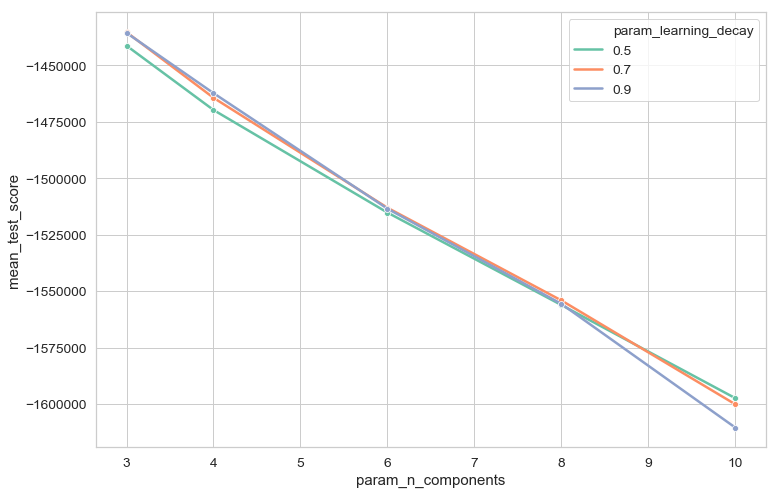

#### Dominant topic in each document

In [43]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(count_data)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_clean))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_clean['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2
Doc0,0.66,0.32,0.01
Doc1,0.08,0.9,0.02
Doc2,0.63,0.18,0.19
Doc3,1,0,0
Doc4,0,0.76,0.24
Doc5,0,1,0
Doc6,0,0.88,0.12
Doc7,0,1,0
Doc8,0,1,0
Doc9,0,0.95,0.05


#### Review topics distribution across documents

In [44]:
df_topic_distribution = df_clean['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,1431
1,1,1184
2,2,775


### Run PyLDA for Visuals

In [45]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis, os

In [46]:
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics)+".lda")

In [47]:
# Takes super long, run only when needed
if RUN_ALL == 1:
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(best_lda_model, count_data, count_vectorizer, mds='tsne')    
    
    LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics)+".lda")

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(panel, f)

In [48]:
if RUN_ALL==1:    
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

    pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')



### Show keywords for topic

In [49]:
# Show top n keywords for each topic
def show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = [str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,health,china,new,company,coronavirus,year,patients,drug,million,virus,people,disease,outbreak,cases,2019
1,people,like,year,new,time,japan,japanese,years,world,make,trump,day,president,work,think
2,fda,drug,market,data,new,use,products,product,information,quality,process,industry,regulatory,companies,company


In [ ]:
train_vecs = []
for i in range(len(rev_train)):
    top_topics = lda_model.get_document_topics(train_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([rev_train.iloc[i].real_counts]) # counts of reviews for restaurant
    topic_vec.extend([len(rev_train.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [51]:
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,topic_words
0,health,china,new,company,coronavirus,year,patients,drug,million,virus,people,disease,outbreak,cases,2019,health china new company coronavirus year pati...
1,people,like,year,new,time,japan,japanese,years,world,make,trump,day,president,work,think,people like year new time japan japanese years...
2,fda,drug,market,data,new,use,products,product,information,quality,process,industry,regulatory,companies,company,fda drug market data new use products product ...


In [146]:
df_clean["lda_output"] = lda_output.tolist()

### Cluster similar documents

In [52]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

clusters = KMeans(n_clusters=3).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.82  0.51  0.26]
 [-0.54  0.84  0.02]]
Perc of Variance Explained: 
 [0.07 0.58]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

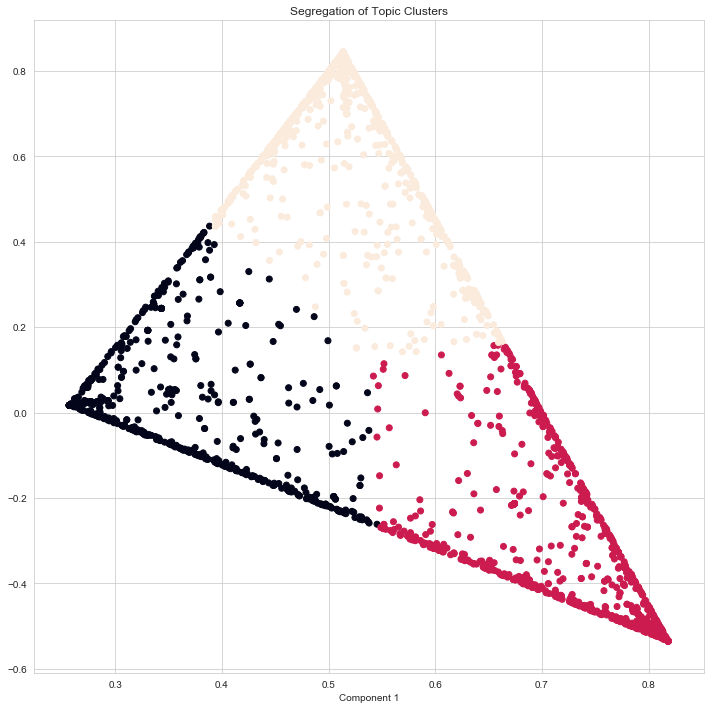

In [53]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

### Get organization labels

In [55]:
import en_core_web_sm
import spacy
from spacy import displacy
from scipy import spatial

nlp = spacy.load('en_core_web_sm')

In [56]:
all_vendors = [x.lower() for x in dataVendor.name]

def compare_lists(orgs, all_vendors=all_vendors, abbvie=True):
    setOrgs = set(orgs)
    setAllVendors = set(all_vendors)
    
    overlap = setOrgs & setAllVendors   
    
    result = float(len(overlap)) / len(setAllVendors) * 100
        
    return result    

In [60]:
def find_org_entities(orgs, all_vendors=all_vendors, abbvie=True):
    setOrgs = set(orgs)
    setAllVendors = set(all_vendors)
    
    overlap = setOrgs & setAllVendors   
              
    return overlap 

In [57]:
def get_org_entities(text):
    txt_nlp = nlp(text)
    ents = []
    for entity in txt_nlp.ents:
        if (entity.label_ == 'ORG'):
            ents.append(entity.text)
    
    return ents    
    

In [58]:
df_clean['all_orgs'] = df_clean['text_processed'].map(lambda x: get_org_entities(x))

In [64]:
df_clean['relevance'] = df_clean['all_orgs'].map(lambda x: compare_lists(x))

In [61]:
df_clean['matching_orgs'] = df_clean['all_orgs'].map(lambda x: find_org_entities(x))

In [65]:
df_clean['relevance'].value_counts()

0.000000    3358
0.137552      28
0.275103       4
Name: relevance, dtype: int64

In [66]:
df_clean['matching_orgs'].value_counts()

{}                     3358
{pfizer}                 20
{ipsos}                   3
{pfizer, merck}           3
{genentech}               1
{general electric}        1
{pfizer, genentech}       1
{colorcon}                1
{basf}                    1
{labcorp}                 1
Name: matching_orgs, dtype: int64

### Define label based on the value range of xbi_daily_change_lesssnp

(array([ 370.,   91.,  113.,   86.,  428.,   73.,  156.,  171.,  249.,
        1653.]),
 array([-9.9990e-01, -7.9991e-01, -5.9992e-01, -3.9993e-01, -1.9994e-01,
         5.0000e-05,  2.0004e-01,  4.0003e-01,  6.0002e-01,  8.0001e-01,
         1.0000e+00]),
 <a list of 10 Patch objects>)

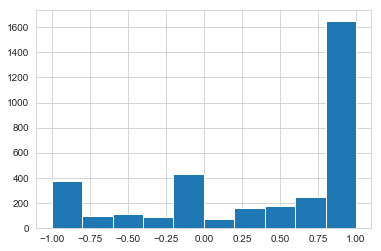

In [67]:
plt.hist(df_clean['article_compound'])

(array([  66.,  142.,  190.,  208., 1852.,  112.,  243.,  366.,  161.,
          50.]),
 array([-0.936 , -0.7478, -0.5596, -0.3714, -0.1832,  0.005 ,  0.1932,
         0.3814,  0.5696,  0.7578,  0.946 ]),
 <a list of 10 Patch objects>)

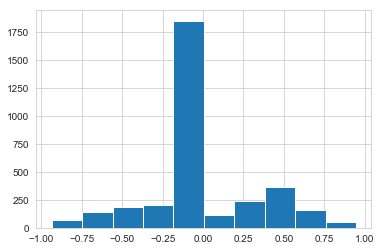

In [68]:
plt.hist(df_clean['title_compound'])

### Strategy 1: Bin first and then calculate weighted average

In [69]:
fbins = [-100000, -0.025, 0, 100000]
risk_categories = [2,1,0]
df_clean['fin_label'] = pd.cut(df_clean['xbi_daily_change_lesssnp'], bins=fbins, labels=risk_categories)

sbins = [-1, -0.25, 0, 1]
risk_categories = [2,1,0]
df_clean['sen_label'] = pd.cut(df_clean['article_compound'], bins=sbins, labels=risk_categories)

In [70]:
df_clean[['fin_label', 'sen_label']] = df_clean[['fin_label','sen_label']].fillna(value=0)

In [71]:
df_clean['fin_label'] = df_clean['fin_label'].astype(int)
df_clean['sen_label'] = df_clean['sen_label'].astype(int)

In [72]:
fin_arr = df_clean['fin_label'].to_numpy()
sen_arr = df_clean['sen_label'].to_numpy()
rel_arr = 1+df_clean['relevance'].to_numpy()

In [73]:
df_clean['label'] = np.round(((rel_arr*fin_arr*0.7)+(rel_arr*sen_arr*0.3))).astype(int)

### Check class balance of dependent variable

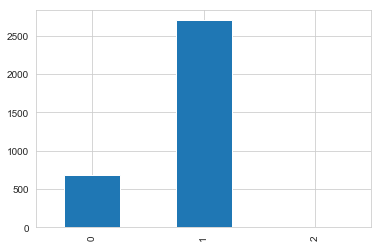

In [74]:
import matplotlib.pyplot as plt
order = ['0','1','2']
s = df_clean['label'].astype(str).value_counts()
s.reindex(np.intersect1d(order, s.index)).plot.bar()


### Strategy 2: Keep weighted average continuous and then bin

In [75]:
fin_c_arr = df_clean['article_compound'].to_numpy()
sen_c_arr = df_clean['xbi_daily_change_lesssnp'].to_numpy()

In [76]:
df_clean['c_label'] = np.round(((rel_arr*fin_c_arr*0.7)+(rel_arr*sen_c_arr*0.3)))

In [77]:
di = {1: "0", 0: "1", -1: "2" }
df_clean.replace({"c_label": di}, inplace=True)

### Check class balance of dependent variable

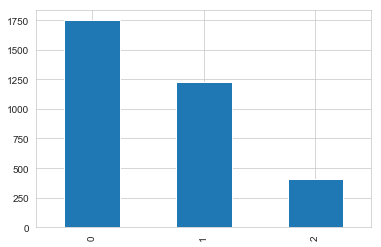

In [78]:
s = df_clean['c_label'].astype(str).value_counts()
s.reindex(np.intersect1d(order, s.index)).plot.bar()

### Load Doc2Vec model trained on wikipedia for feature extraction

In [79]:
from sklearn import metrics
 
import gensim.models as g
import codecs

model="doc2vec/doc2vec.bin"  
#inference hyper-parameters
start_alpha=0.01
infer_epoch=1000
 
#load model
m = g.Doc2Vec.load(model)

C:\Users\sriva\Anaconda3\envs\py37torch\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [80]:
def vectorize_text(text_column):
    #Convert article text to vector values
    list_txt_article = [x.strip().split() for x in text_column]

    X_article =[]
    for d in list_txt_article:

        X_article.append(m.infer_vector(d, alpha=start_alpha, steps=infer_epoch) )
    
    return X_article


In [81]:
X_text_features = vectorize_text(df_clean['text_processed'])

In [82]:
# save elmo_train_new
pickle_out = open("doc2vec_train_03042020.pickle","wb")
pickle.dump(X_text_features, pickle_out)
pickle_out.close()

In [83]:
# load elmo_train_new
pickle_in = open("doc2vec_train_03042020.pickle", "rb")
X_text_features = pickle.load(pickle_in)

### Run Birch Clustering 
 1. Numeric data 
 2. Text features


In [84]:
num_columns = [ 'se_abbv_close', 'se_abbv_open',
        'se_snp_close', 
       'se_snp_open', 'se_xbi_close',
        'se_xbi_open', 'article_neg',
       'article_neu', 'article_pos', 'article_compound', 'title_neg',
       'title_neu', 'title_pos', 'title_compound', 
       'spx_daily_change', 'xbi_daily_change',
       'xbi_daily_change_lesssnp', 'dominant_topic', 'relevance']

In [85]:
df_clean.columns

Index(['id', 'se_abbv_close', 'se_abbv_open', 'se_is_risk', 'se_risk_rating',
       'se_sentimentpolarity', 'se_sentimentscore', 'se_snp_close',
       'se_snp_open', 'se_xbi_close', 'se_xbi_open', 'source', 'text', 'title',
       'url', 'se_index', 'se_org_entity_list', 'article_neg', 'article_neu',
       'article_pos', 'article_compound', 'title_neg', 'title_neu',
       'title_pos', 'title_compound', 'text_processed', 'spx_daily_change',
       'xbi_daily_change', 'abbv_daily_change', 'xbi_daily_change_lesssnp',
       'dominant_topic', 'all_orgs', 'matching_orgs', 'relevance', 'fin_label',
       'sen_label', 'label', 'c_label'],
      dtype='object')

In [86]:
df_birch = df_clean[num_columns]

In [87]:
df_birch = df_birch.replace(r'^\s*$', np.nan, regex=True)
df_birch.fillna(0, inplace=True)

In [88]:
X_num_birch = df_birch.to_numpy()

In [89]:
from sklearn.cluster import Birch

#Attempting to cluster in 3 clusters
k=3

#Clustering One of all financial and sentiments plus topic words vector
brc_num = Birch(branching_factor=50, n_clusters=k, threshold=0.1, compute_labels=True)
brc_num.fit(X_num_birch)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
   threshold=0.1)

In [90]:
#Clustering Two of article text vector
brc_article = Birch(branching_factor=50, n_clusters=k, threshold=0.1, compute_labels=True)
brc_article.fit(X_text_features)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
   threshold=0.1)

In [91]:
num_clusters = brc_num.predict(X_num_birch) 
num_labels = brc_num.labels_
 
 
print ("Clusters: ")
print (num_labels)
 
 
silhouette_score = metrics.silhouette_score(X_num_birch, num_labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Clusters: 
[0 0 0 ... 0 0 0]
Silhouette_score: 
0.8109158647877873


In [92]:
article_clusters = brc_article.predict(X_text_features) 
article_labels = brc_article.labels_
 
 
print ("Clusters: ")
print (article_labels)
 
 
silhouette_score = metrics.silhouette_score(X_text_features, article_labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Clusters: 
[1 1 1 ... 1 1 1]
Silhouette_score: 
0.013442994


In [147]:
df_clean["num_cluster"] = num_labels

# Dropped due to poor silhouette score
#df_clean["article_cluster"] = article_labels

### Train classification model based on processed data

In [148]:
num_features = ['se_abbv_close', 'se_abbv_open',
        'se_snp_close',
        'se_snp_open', 
       'se_xbi_close',  'se_xbi_open',
        'article_neg',
       'article_neu', 'article_pos', 'article_compound', 'title_neg',
       'title_neu', 'title_pos', 'title_compound', 
       'spx_daily_change', 'xbi_daily_change', 'xbi_daily_change_lesssnp',
       'dominant_topic', 'relevance', 'num_cluster', 'lda_output']

dependent_variable = ['label']
c_dependent_variable = [ 'c_label']

In [149]:
df_train = df_clean[num_features]

In [154]:
df_train = df_train.replace(r'^\s*$', np.nan, regex=True)
df_train.fillna(0, inplace=True)

### Combine all features and predict 

In [156]:
X_text_num_all = pd.DataFrame.from_records(X_text_features, df_train.to_numpy())

#Use continuous label
y_c = df_clean[c_dependent_variable]

#Split data sets 70/30
X_train, x_test, Y_train, y_test = train_test_split(X_text_num_all, y_c, test_size=0.2)

In [ ]:
df1.index = pd.to_datetime(df1.index)
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
df1 = df1.set_index('TIMESTAMP')
df1 = df1.resample('1d').mean()
ax = sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5)

In [212]:
corr = df_train.corr()

C:\Users\sriva\Anaconda3\envs\py37torch\lib\site-packages\seaborn\palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
C:\Users\sriva\Anaconda3\envs\py37torch\lib\site-packages\seaborn\palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


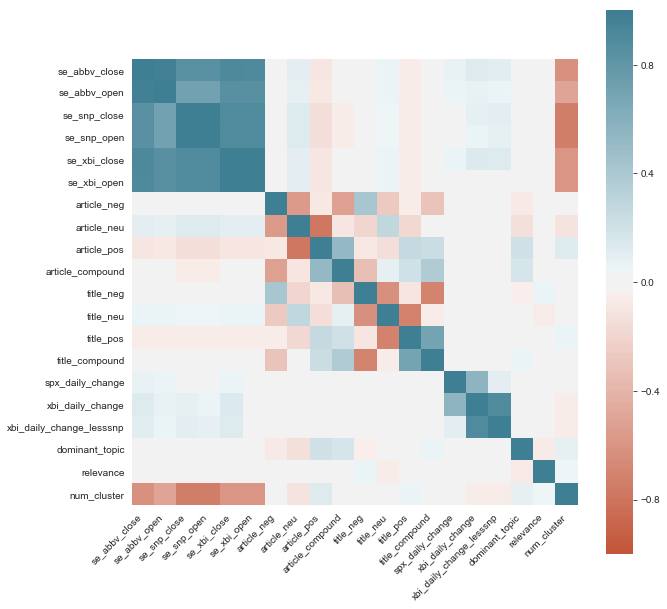

In [220]:
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True

fig, ax1 = plt.subplots(figsize=(10,10))         # Sample figsize in inches

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax=ax1
    #, mask=mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    
);

In [157]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# fit model no training data
model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [158]:
xgb_predictions = model.predict(x_test)

# evaluate predictions
accuracy = accuracy_score(y_test, xgb_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 75.96%


In [101]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [102]:
random_forest_predictions = random_forest.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, random_forest_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.45%


In [135]:
from sklearn.metrics import cohen_kappa_score

In [105]:
from sklearn.metrics import precision_recall_fscore_support

In [131]:
from sklearn.metrics import balanced_accuracy_score

### Model tuning and plotting learning curves

In [160]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1812)

In [161]:
#XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier()
param_grid = {'max_depth': [5,6,7], 'gamma': [1, 2], 'learning_rate': [0.1, 0.2, 0.3]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=kfold, verbose=1, n_jobs= -1)
xgb_grid.fit(X_train,Y_train)

# Best score
xgb_best = xgb_grid.best_estimator_
xgb_grid.best_score_

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  5.9min finished


0.7688053097345132

In [203]:
#Gradient Boosting
GBClassifier = GradientBoostingClassifier()

param_grid = {'max_depth': [5,6,7], 'learning_rate': [0.1, 0.2, 0.3]}

GBGrid = GridSearchCV(GBClassifier, param_grid, cv = kfold, n_jobs= -1, verbose = 1)

GBGrid.fit(X_train,Y_train)

# Best score
GB_best = GBGrid.best_estimator_
GBGrid.best_score_

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.8min finished


0.7739675516224189

In [165]:
# Random Forest
random_forest = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [6,7,8,9,10],  
              'min_samples_split': [5, 6, 7, 8]}

gsrandom_forest = GridSearchCV(random_forest,param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsrandom_forest.fit(X_train,Y_train)
# Best score
random_forest_best = gsrandom_forest.best_estimator_
gsrandom_forest.best_score_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.7s finished


0.7186578171091446

In [166]:
# ExtraTrees 
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth': [6,7,8,9], 'max_features': [7,8,9,10],  
              'n_estimators': [50, 100, 200]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    8.9s finished


0.7234513274336283

In [167]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(b=True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt


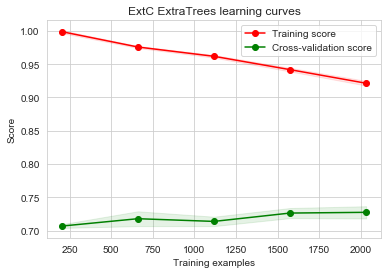

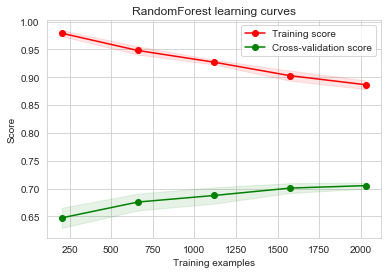

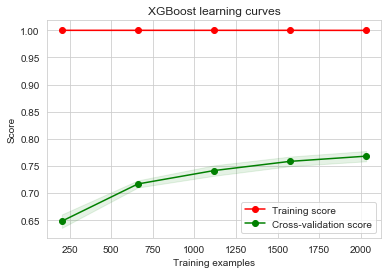

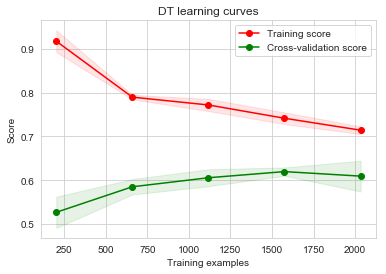

In [168]:
g = plot_learning_curve(gsExtC.best_estimator_,"ExtC ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsrandom_forest.best_estimator_,"RandomForest learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(xgb_grid.best_estimator_,"XGBoost learning curves",X_train,Y_train,cv=kfold)

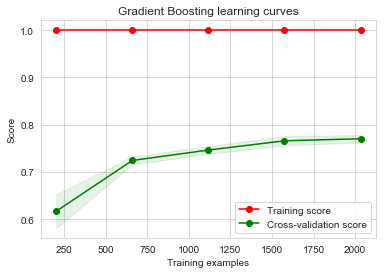

In [205]:
g = plot_learning_curve(GBGrid.best_estimator_,"Gradient Boosting learning curves",X_train,Y_train,cv=kfold)

In [169]:
import seaborn as sns

In [242]:
test_ExtC = pd.Series(ExtC_best.predict(x_test), name="ExtC")
test_random_forest = pd.Series(random_forest_best.predict(x_test), name="random_forest")
test_XG = pd.Series(xgb_best.predict(x_test), name="XGB")
test_GB = pd.Series(GB_best.predict(x_test), name="GB")

# Concatenate all classifier results
ensemble_results = pd.concat([test_ExtC, test_random_forest, test_XG, test_GB],axis=1)

In [222]:
precision_recall_fscore_support(y_test, test_ExtC, average='weighted')

(0.771903551335549, 0.7035398230088495, 0.6545613684694472, None)

In [223]:
precision_recall_fscore_support(y_test, test_random_forest, average='weighted')

(0.7080721654525007, 0.7020648967551623, 0.6600153588883256, None)

In [224]:
precision_recall_fscore_support(y_test, test_XG, average='weighted')

(0.8052069951019584, 0.775811209439528, 0.7506424029284551, None)

In [227]:
precision_recall_fscore_support(y_test, test_GB, average='weighted')

(0.785000101749095, 0.7817109144542773, 0.759533464000087, None)

In [235]:
cohen_kappa_score(y_test, test_random_forest)

0.4303563704122717

In [236]:
cohen_kappa_score(y_test, test_XG)

0.5818347075245082

In [237]:
cohen_kappa_score(y_test, test_ExtC)

0.4241150096559767

In [238]:
cohen_kappa_score(y_test, test_GB)

0.596017504941885

In [243]:
train_ExtC = pd.Series(ExtC_best.predict(X_train), name="ExtC")
train_random_forest = pd.Series(random_forest_best.predict(X_train), name="random_forest")
train_XG = pd.Series(xgb_best.predict(X_train), name="XGB")
train_GB = pd.Series(GB_best.predict(X_train), name="GB")

# Concatenate all classifier results
df_stack = pd.concat([train_ExtC, train_random_forest, train_XG, train_GB],axis=1)

In [244]:
df_stack.shape

(2712, 4)

In [245]:
len(Y_train)

2712

In [248]:
# Random Forest Stacked
random_forest_stacked = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 6, 7, 8], 'min_samples_split': [5, 6, 7, 8]}

gsrandom_forest_stacked = GridSearchCV(random_forest_stacked,param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)



gsrandom_forest_stacked.fit(df_stack,Y_train)
# Best score
random_forest_best_stacked = gsrandom_forest_stacked.best_estimator_
gsrandom_forest_stacked.best_score_

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.1s finished


1.0

In [250]:
random_forest_stacked = RandomForestClassifier()

random_forest_stacked.fit(df_stack, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [252]:
random_forest_stacked_predictions = random_forest_stacked.predict(ensemble_results)

In [253]:
precision_recall_fscore_support(y_test, random_forest_stacked_predictions, average='weighted')

(0.8080052981428102, 0.7802359882005899, 0.7528942345519228, None)

In [254]:
cohen_kappa_score(y_test, random_forest_stacked_predictions)

0.5907671242865303

In [256]:
VotingPredictor = VotingClassifier(estimators=[('XGB', xgb_best),
                                               ('ExtC',ExtC_best),                                                
                                               ('random_forest', random_forest_best),
                                              ('GB', GB_best),], voting='soft', n_jobs=4)
VotingPredictor = VotingPredictor.fit(X_train, Y_train)

In [257]:
VotingPredictor_predictions = VotingPredictor.predict(x_test)


In [258]:
precision_recall_fscore_support(y_test, VotingPredictor_predictions, average='weighted')

(0.8126065687779854, 0.7772861356932154, 0.7479748199414087, None)

In [259]:
cohen_kappa_score(y_test, VotingPredictor_predictions)

0.5813565490478314

### Save trained models

In [109]:
lda_topic_model = 'best_lda_model.sav' #best_lda_model
count_vector_model = 'count_vectorizer_model.sav' #count_vectorizer
birch_num_model = 'birch_num_model.sav' #brc_topic
xgb_classifier = 'xgb_classifier.sav' #random_forest

In [110]:
# save the models to disk
pickle.dump(best_lda_model, open(lda_topic_model, 'wb'))
pickle.dump(count_vectorizer, open(count_vector_model, 'wb'))
pickle.dump(brc_num, open(birch_num_model, 'wb'))
pickle.dump(model, open(xgb_classifier, 'wb'))

### Update field of articles 

In [111]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3426
Data columns (total 40 columns):
id                          3390 non-null object
se_abbv_close               3390 non-null float64
se_abbv_open                3390 non-null float64
se_is_risk                  3390 non-null bool
se_risk_rating              3390 non-null int64
se_sentimentpolarity        0 non-null float64
se_sentimentscore           0 non-null float64
se_snp_close                3390 non-null float64
se_snp_open                 3390 non-null float64
se_xbi_close                3390 non-null float64
se_xbi_open                 3390 non-null float64
source                      3390 non-null object
text                        3390 non-null object
title                       3390 non-null object
url                         3390 non-null object
se_index                    3390 non-null float64
se_org_entity_list          0 non-null float64
article_neg                 3390 non-null float64
article_neu 

In [115]:
df_clean['se_is_risk'] = np.where(df_clean["c_label"]=='0', False, True)
df_clean['se_risk_rating'] = df_clean["c_label"].astype(int)

In [116]:
df_clean['se_sentimentscore'] = df_clean["article_compound"].astype(float)

In [117]:
df_clean['se_sentimentpolarity'] = np.where(df_clean["title_pos"]>=df_clean["title_neg"], df_clean["title_pos"], df_clean["title_neg"])

In [118]:
#Need to switch to only relevant entities
#df_clean['se_org_entity_list'] = df_clean['all_orgs'].map(lambda x: " ".join(x))
df_clean['se_org_entity_list'] = df_clean['matching_orgs'].map(lambda x: " ".join(x))

In [119]:
update_cols = ['se_is_risk', 'se_risk_rating',
       'se_sentimentpolarity', 'se_sentimentscore']

#'all_orgs' needs to be found a home in ES

In [120]:
UPDATE_COLS = ['id', 'SE_Is_Risk', 'SE_Risk_Rating', 'SE_SentimentPolarity', 'SE_SentimentScore','SE_index', 'SE_org_entity_list']

In [121]:
update_data_se_cols = \
df_clean[['id', 'se_is_risk', 'se_risk_rating', 'se_sentimentpolarity', 'se_sentimentscore', 'xbi_daily_change_lesssnp',\
          'se_org_entity_list' ]]

In [122]:
update_data_se_cols.columns = ['id', 'SE_Is_Risk', 'SE_Risk_Rating',  'SE_SentimentPolarity', \
               'SE_SentimentScore','SE_index', 'SE_org_entity_list']

In [123]:
update_data_se_cols.head()

,id,SE_Is_Risk,SE_Risk_Rating,SE_SentimentPolarity,SE_SentimentScore,SE_index,SE_org_entity_list
0,Mow5VnABSS55QcLamKPN,True,2,0.000,-0.9169,-0.000925,
1,QYw5VnABSS55QcLamKPN,False,0,0.276,0.8481,-0.000925,
2,Qow5VnABSS55QcLamKPN,False,0,0.344,0.8658,-0.000925,
3,VIwxVnABSS55QcLaDJTr,False,0,0.000,0.9925,0.001599,
4,wNQ5VnABDgJSMfkqwWd1,True,2,0.500,-0.9985,-0.006601,


In [124]:
updated_ids = update_data(es, INDEX_NAME, update_data_se_cols)
print("Articles Updated:", len(updated_ids))

Articles Updated: 3390


In [125]:
from sklearn.manifold import TSNE

In [126]:
tsne_wp_3d = TSNE(n_components=3, init='pca', random_state=12)
    #perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(X_text_features)



In [127]:
x = embeddings_wp_3d[:,0]
y = embeddings_wp_3d[:,1]
group = df_clean["c_label"]
color_dict = {'2': 'red', '1': 'yellow', '0': 'green'}


In [128]:
df_tsne = pd.DataFrame(list(zip(x, y, group)), 
               columns =['x', 'y', 'Risk']) 

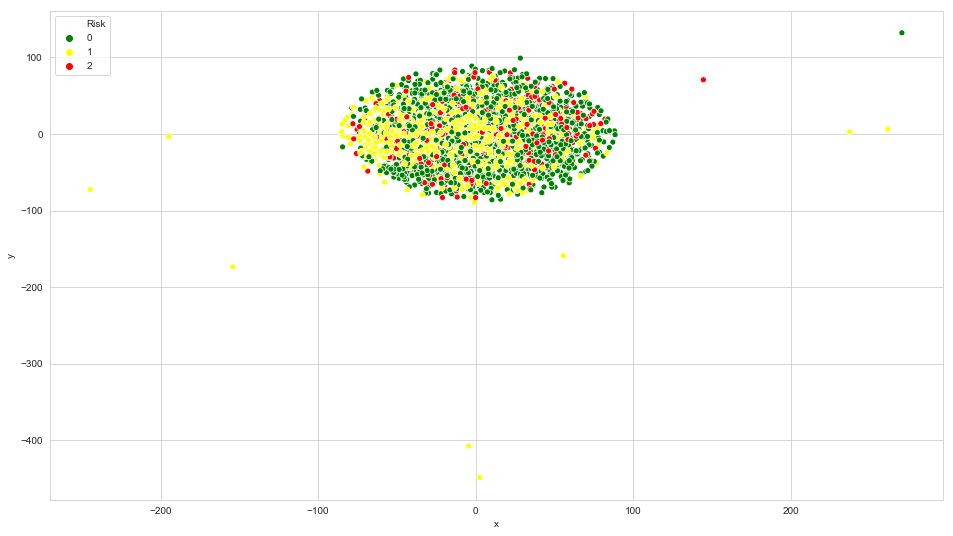

In [129]:
import seaborn as sns
fig_dims = (16, 9)
fig, ax = plt.subplots(figsize=fig_dims)
#sns.barplot(x = "names", y = "values", ax=ax, data=df)
sns.scatterplot(x="x", y="y", ax=ax, hue="Risk",
              data=df_tsne, palette=color_dict, 
                   legend='full')
#g.set(xscale="log")

In [192]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

clustersx = KMeans(n_clusters=3).fit_predict(X_text_features)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
d2vec_output_svd = svd_model.fit_transform(X_text_features)

# X and Y axes of the plot using SVD decomposition
x = d2vec_output_svd[:, 0]
y = d2vec_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[-0.02 -0.01 -0.05 -0.03 -0.04 -0.01  0.07  0.01 -0.04 -0.   -0.1  -0.01
  -0.05 -0.04  0.09  0.07 -0.02 -0.04  0.03 -0.02 -0.03  0.    0.06 -0.03
   0.18  0.01 -0.03 -0.01 -0.06 -0.17 -0.05  0.09 -0.03 -0.02  0.04  0.01
   0.06 -0.05  0.04 -0.06  0.03  0.09  0.   -0.02  0.05 -0.09  0.07  0.09
   0.03 -0.08 -0.02 -0.04  0.04 -0.05  0.12 -0.    0.04  0.04 -0.16 -0.03
  -0.04  0.03 -0.06 -0.01  0.05 -0.02  0.01 -0.12  0.1   0.05  0.09 -0.02
   0.    0.02 -0.04  0.03 -0.01  0.1   0.01 -0.04 -0.01 -0.03  0.04 -0.03
  -0.02 -0.02  0.   -0.04 -0.01 -0.02 -0.05 -0.13  0.08 -0.08 -0.11  0.02
   0.04  0.04  0.03 -0.06 -0.12  0.01  0.06 -0.    0.03 -0.06  0.07  0.06
  -0.05 -0.06 -0.06 -0.05 -0.03  0.03 -0.01  0.    0.01  0.01 -0.02  0.03
  -0.02 -0.06 -0.04  0.03 -0.03  0.05  0.12 -0.05  0.08  0.06  0.04  0.02
   0.05 -0.05 -0.01 -0.02 -0.02 -0.   -0.05 -0.05 -0.01 -0.03  0.1   0.
   0.03 -0.01 -0.05  0.02  0.12  0.02  0.03 -0.05  0.05 -0.05  0.03 -0.02
   0.03 -0.12  0.

Text(0.5, 1.0, 'Segregation of Text Features Clusters')

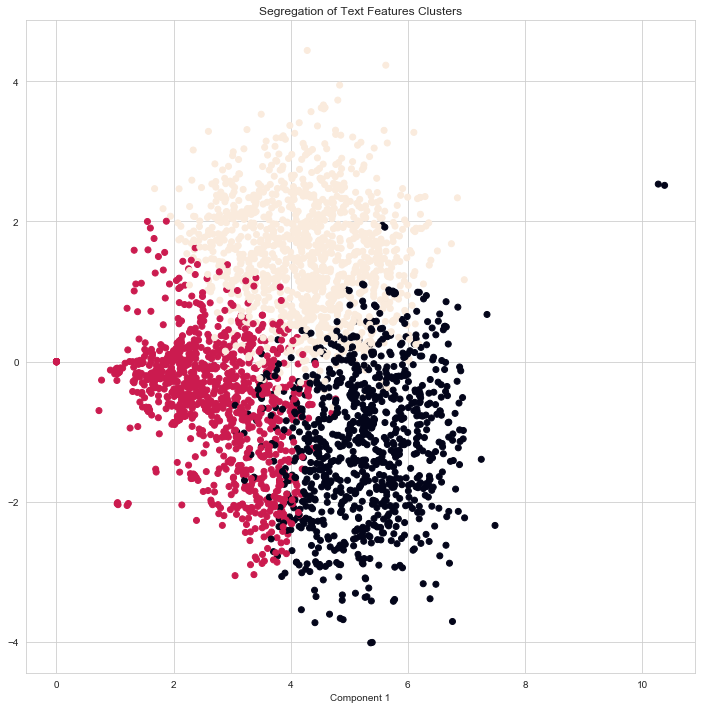

In [194]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clustersx)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Text Features Clusters", )